In [2]:
!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
myfolder = '../Data/'

In [5]:
prior = pd.read_csv(myfolder + 'order_products__prior.csv', dtype={'order_id': np.uint32,
           'product_id': np.uint16, 'reordered': np.uint8, 'add_to_cart_order': np.uint8})

train_orders = pd.read_csv(myfolder + 'order_products__train.csv', dtype={'order_id': np.uint32,
           'product_id': np.uint16, 'reordered': np.int8, 'add_to_cart_order': np.uint8 })

orders = pd.read_csv(myfolder + 'orders.csv', dtype={'order_hour_of_day': np.uint8,
           'order_number': np.uint8, 'order_id': np.uint32, 'user_id': np.uint32,
           'order_dow': np.uint8, 'days_since_prior_order': np.float16})

orders.eval_set = orders.eval_set.replace({'prior': 0, 'train': 1, 'test':2}).astype(np.uint8)
orders.days_since_prior_order = orders.days_since_prior_order.fillna(30).astype(np.uint8)

products = pd.read_csv(myfolder + 'products.csv', dtype={'product_id': np.uint16,
            'aisle_id': np.uint8, 'department_id': np.uint8},
             usecols=['product_id', 'aisle_id', 'department_id'])

print('done loading')

done loading


In [6]:
print('merge prior and orders and keep train separate ...')

orders_products = orders.merge(prior, how = 'inner', on = 'order_id')
train_orders = train_orders.merge(orders[['user_id','order_id']], left_on = 'order_id', right_on = 'order_id', how = 'inner')

del prior
gc.collect()

merge prior and orders and keep train separate ...


0

In [7]:
print('Creating features I ...')

# sort orders and products to get the rank or the reorder frequency
prdss = orders_products.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)
prdss['product_time'] = prdss.groupby(['user_id', 'product_id']).cumcount()+1

# getting products ordered first and second times to calculate probability later
sub1 = prdss[prdss['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prdss[prdss['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')
sub1['prod_orders'] = prdss.groupby('product_id')['product_id'].size()
sub1['prod_reorders'] = prdss.groupby('product_id')['reordered'].sum()
sub2 = sub2.reset_index().merge(sub1.reset_index())
sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_ratio']]

del sub1, sub2, prdss
gc.collect()

Creating features I ...


0

In [8]:
print('Creating features II ...')

# extracting prior information (features) by user
users = orders[orders['eval_set'] == 0].groupby(['user_id'])['order_number'].max().to_frame('user_orders')
users['user_period'] = orders[orders['eval_set'] == 0].groupby(['user_id'])['days_since_prior_order'].sum()
users['user_mean_days_since_prior'] = orders[orders['eval_set'] == 0].groupby(['user_id'])['days_since_prior_order'].mean()

# merging features about users and orders into one dataset
us = orders_products.groupby('user_id').size().to_frame('user_total_products')
us['eq_1'] = orders_products[orders_products['reordered'] == 1].groupby('user_id')['product_id'].size()
us['gt_1'] = orders_products[orders_products['order_number'] > 1].groupby('user_id')['product_id'].size()
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1']
us.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)
us['user_distinct_products'] = orders_products.groupby(['user_id'])['product_id'].nunique()

# the average basket size of the user
users = users.reset_index().merge(us.reset_index())
users['user_average_basket'] = users['user_total_products'] / users['user_orders']

us = orders[orders['eval_set'] != 0]
us = us[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users = users.merge(us)

del us
gc.collect()

Creating features II ...


0

In [9]:
print('Finalizing features and the main data file  ...')
# merging orders and products and grouping by user and product and calculating features for the user/product combination
data = orders_products.groupby(['user_id', 'product_id']).size().to_frame('up_orders')
data['up_first_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].min()
data['up_last_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].max()
data['up_average_cart_position'] = orders_products.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data = data.reset_index()

#merging previous data with users
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

#user/product combination features about the particular order
data['up_order_rate'] = data['up_orders'] / data['user_orders']
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']
data = data.merge(train_orders[['user_id', 'product_id', 'reordered']], 
                  how = 'left', on = ['user_id', 'product_id'])
data = data.merge(products, on = 'product_id')

del orders_products     #, orders, train_orders
gc.collect()

Finalizing features and the main data file  ...


0

In [10]:
print(' Training and test data for later use in F1 optimization and training  ...')

#save the actual reordered products of the train set in a list format and then delete the original frames
train_orders = train_orders[train_orders['reordered']==1].drop('reordered',axis=1)
orders.set_index('order_id', drop=False, inplace=True)
train1=orders[['order_id','eval_set']].loc[orders['eval_set']==1]
train1['actual'] = train_orders.groupby('order_id').aggregate({'product_id':lambda x: list(x)})
train1['actual']=train1['actual'].fillna('')
n_actual = train1['actual'].apply(lambda x: len(x)).mean()   # this is the average cart size

test1=orders[['order_id','eval_set']].loc[orders['eval_set']==2]
test1['actual']=' '
traintest1=pd.concat([train1,test1])
traintest1.set_index('order_id', drop=False, inplace=True)

del orders, train_orders, train1, test1
gc.collect()

 Training and test data for later use in F1 optimization and training  ...


0

In [11]:
print('setting dtypes for data ...')

#reduce the size by setting data types
data = data.astype(dtype= {'user_id' : np.uint32, 'product_id'  : np.uint16,
            'up_orders'  : np.uint8, 'up_first_order' : np.uint8, 'up_last_order' : np.uint8,
            'up_average_cart_position' : np.uint8, 'prod_orders' : np.uint16, 
            'prod_reorder_probability' : np.float16,   
            'prod_reorder_ratio' : np.float16, 'user_orders' : np.uint8,
            'user_period' : np.uint8, 'user_mean_days_since_prior' : np.uint8,
            'user_total_products' : np.uint8, 'user_reorder_ratio' : np.float16, 
            'user_distinct_products' : np.uint8, 'user_average_basket' : np.uint8,
            'order_id'  : np.uint32, 'eval_set' : np.uint8, 
            'days_since_prior_order' : np.uint8, 'up_order_rate' : np.float16, 
            'up_orders_since_last_order':np.uint8,
            'aisle_id': np.uint8, 'department_id': np.uint8})

data['reordered'].fillna(0, inplace=True)  # replace NaN with zeros (not reordered) 
data['reordered']=data['reordered'].astype(np.uint8)

gc.collect()

setting dtypes for data ...


0

In [12]:
print('Preparing Train and Test sets ...')

# filter by eval_set (train=1, test=2) and dropp the id's columns (not part of training features) 
# but keep prod_id and user_id in test

train = data[data['eval_set'] == 1].drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1)
test =  data[data['eval_set'] == 2].drop(['eval_set', 'user_id', 'reordered'], axis = 1)

check =  data.drop(['eval_set', 'user_id', 'reordered'], axis = 1)

del data
gc.collect()

Preparing Train and Test sets ...


20

In [13]:
print('preparing X,y for LightGBM ...')

X_train, X_eval, y_train, y_eval = train_test_split(
    train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.1, random_state=2)

del train
gc.collect()

preparing X,y for LightGBM ...


20

In [14]:
print('formatting and training LightGBM ...')

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)

# there is some room to change the parameters and improve - I have not done it systematically

params = {'task': 'train', 'boosting_type': 'gbdt',   'objective': 'binary', 'metric': {'binary_logloss', 'auc'},
    'num_iterations' : 1000, 'max_bin' : 100, 'num_leaves': 512, 'feature_fraction': 0.8,  'bagging_fraction': 0.95,
    'bagging_freq': 5, 'min_data_in_leaf' : 200, 'learning_rate' : 0.05}

# set lower num_boost_round (I used 300 instead of 50 at home) to avoid time-out on Kaggle

lgb_model = lgb.train(params, lgb_train, num_boost_round = 50, valid_sets = lgb_eval, early_stopping_rounds=10)

del lgb_train, X_train, y_train
gc.collect()

formatting and training LightGBM ...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 745484, number of negative: 6864677
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.967337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 7610161, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097959 -> initscore=-2.220111
[LightGBM] [Info] Start training from score -2.220111
[1]	valid_0's binary_logloss: 0.311859	valid_0's auc: 0.824706
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.305051	valid_0's auc: 0.825159
[3]	valid_0's binary_logloss: 0.298931	valid_0's auc: 0.82722
[4]	valid_0's binary_logloss: 0.293699	valid_0's auc: 0.828096
[5]	valid_0's binary_logloss: 0.289304	valid_0's auc: 0.828411
[6]	valid_0's binary_logloss: 0.285422	valid_0's auc: 0.828953
[7]	valid_0's binary_logloss: 0.28202	valid_0's auc: 0.82907

[121]	valid_0's binary_logloss: 0.244342	valid_0's auc: 0.836053
[122]	valid_0's binary_logloss: 0.244322	valid_0's auc: 0.836087
[123]	valid_0's binary_logloss: 0.244304	valid_0's auc: 0.836116
[124]	valid_0's binary_logloss: 0.244298	valid_0's auc: 0.836127
[125]	valid_0's binary_logloss: 0.244281	valid_0's auc: 0.836153
[126]	valid_0's binary_logloss: 0.244269	valid_0's auc: 0.836178
[127]	valid_0's binary_logloss: 0.24424	valid_0's auc: 0.836228
[128]	valid_0's binary_logloss: 0.244222	valid_0's auc: 0.836253
[129]	valid_0's binary_logloss: 0.244203	valid_0's auc: 0.836286
[130]	valid_0's binary_logloss: 0.244187	valid_0's auc: 0.836306
[131]	valid_0's binary_logloss: 0.244182	valid_0's auc: 0.836312
[132]	valid_0's binary_logloss: 0.244176	valid_0's auc: 0.836322
[133]	valid_0's binary_logloss: 0.244163	valid_0's auc: 0.836346
[134]	valid_0's binary_logloss: 0.244138	valid_0's auc: 0.83638
[135]	valid_0's binary_logloss: 0.244135	valid_0's auc: 0.836387
[136]	valid_0's binary_logl

[248]	valid_0's binary_logloss: 0.243282	valid_0's auc: 0.83781
[249]	valid_0's binary_logloss: 0.243279	valid_0's auc: 0.837815
[250]	valid_0's binary_logloss: 0.243265	valid_0's auc: 0.837842
[251]	valid_0's binary_logloss: 0.243256	valid_0's auc: 0.837855
[252]	valid_0's binary_logloss: 0.243245	valid_0's auc: 0.837874
[253]	valid_0's binary_logloss: 0.243238	valid_0's auc: 0.837884
[254]	valid_0's binary_logloss: 0.24323	valid_0's auc: 0.8379
[255]	valid_0's binary_logloss: 0.243225	valid_0's auc: 0.837907
[256]	valid_0's binary_logloss: 0.243215	valid_0's auc: 0.837927
[257]	valid_0's binary_logloss: 0.243205	valid_0's auc: 0.837942
[258]	valid_0's binary_logloss: 0.2432	valid_0's auc: 0.837949
[259]	valid_0's binary_logloss: 0.243192	valid_0's auc: 0.837961
[260]	valid_0's binary_logloss: 0.243182	valid_0's auc: 0.837977
[261]	valid_0's binary_logloss: 0.243178	valid_0's auc: 0.837981
[262]	valid_0's binary_logloss: 0.243177	valid_0's auc: 0.837982
[263]	valid_0's binary_logloss:

[375]	valid_0's binary_logloss: 0.242768	valid_0's auc: 0.838677
[376]	valid_0's binary_logloss: 0.242758	valid_0's auc: 0.83869
[377]	valid_0's binary_logloss: 0.242751	valid_0's auc: 0.838701
[378]	valid_0's binary_logloss: 0.242742	valid_0's auc: 0.838711
[379]	valid_0's binary_logloss: 0.242741	valid_0's auc: 0.838713
[380]	valid_0's binary_logloss: 0.24274	valid_0's auc: 0.838713
[381]	valid_0's binary_logloss: 0.242741	valid_0's auc: 0.838709
[382]	valid_0's binary_logloss: 0.242743	valid_0's auc: 0.838707
[383]	valid_0's binary_logloss: 0.242743	valid_0's auc: 0.838706
[384]	valid_0's binary_logloss: 0.242741	valid_0's auc: 0.838709
[385]	valid_0's binary_logloss: 0.242736	valid_0's auc: 0.838717
[386]	valid_0's binary_logloss: 0.242732	valid_0's auc: 0.838726
[387]	valid_0's binary_logloss: 0.24273	valid_0's auc: 0.838731
[388]	valid_0's binary_logloss: 0.242721	valid_0's auc: 0.838742
[389]	valid_0's binary_logloss: 0.24272	valid_0's auc: 0.838744
[390]	valid_0's binary_loglos

[502]	valid_0's binary_logloss: 0.24243	valid_0's auc: 0.83926
[503]	valid_0's binary_logloss: 0.242426	valid_0's auc: 0.839267
[504]	valid_0's binary_logloss: 0.242425	valid_0's auc: 0.839267
[505]	valid_0's binary_logloss: 0.242423	valid_0's auc: 0.83927
[506]	valid_0's binary_logloss: 0.242416	valid_0's auc: 0.839282
[507]	valid_0's binary_logloss: 0.24241	valid_0's auc: 0.839293
[508]	valid_0's binary_logloss: 0.242409	valid_0's auc: 0.839296
[509]	valid_0's binary_logloss: 0.242404	valid_0's auc: 0.839305
[510]	valid_0's binary_logloss: 0.242402	valid_0's auc: 0.839308
[511]	valid_0's binary_logloss: 0.242403	valid_0's auc: 0.839306
[512]	valid_0's binary_logloss: 0.2424	valid_0's auc: 0.839311
[513]	valid_0's binary_logloss: 0.2424	valid_0's auc: 0.839309
[514]	valid_0's binary_logloss: 0.242397	valid_0's auc: 0.839317
[515]	valid_0's binary_logloss: 0.242394	valid_0's auc: 0.839323
[516]	valid_0's binary_logloss: 0.242389	valid_0's auc: 0.839329
[517]	valid_0's binary_logloss: 0

134

In [15]:
# Define an auxiliary function to combine the product data into orders

def combi(z,df):
    
    prd_bag = dict()
    z_bag = dict()
    for row in df.itertuples():
        if row.reordered > z:   
            try:
                prd_bag[row.order_id] += ' ' + str(row.product_id)
                z_bag[row.order_id]+= ' ' + str(int(100*row.reordered))
            except:
                prd_bag[row.order_id] = str(row.product_id)
                z_bag[row.order_id]= str(int(100*row.reordered))

    for order in df.order_id:
        if order not in prd_bag:
            prd_bag[order] = ' '
            z_bag[order] = ' '

    return prd_bag,z_bag 

In [16]:
# F1 function uses the actual products as a list in the train set and the list of predicted products

def f1_score_single(x):                 #from LiLi but modified to get 1 for both empty

    y_true = x.actual
    y_pred = x.list_prod
    if y_true == '' and y_pred ==[] : return 1.
    y_true = set(y_true)
    y_pred = set(y_pred)
    cross_size = len(y_true & y_pred)
    if cross_size == 0: return 0.
    p = 1. * cross_size / len(y_pred)
    r = 1. * cross_size / len(y_true)
    return 2 * p * r / (p + r)

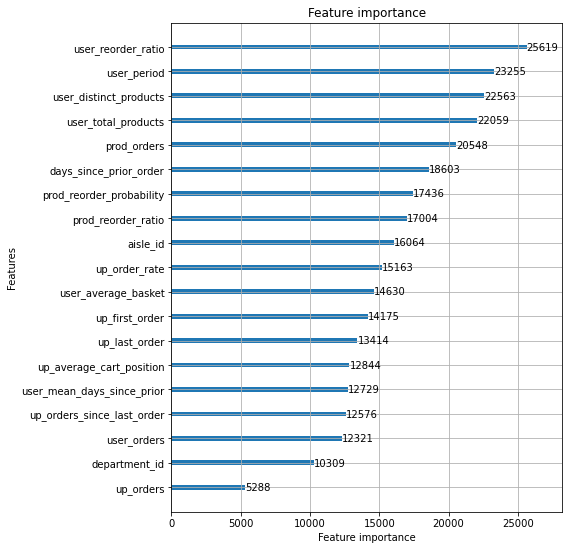

In [17]:
# check feature importance
lgb.plot_importance(lgb_model, figsize=(7,9))
plt.show()

In [18]:
print(' Applying model to all data - both train and test ')


check['reordered'] = lgb_model.predict(check[check.columns.difference(
    ['order_id', 'product_id'])], num_iteration = lgb_model.best_iteration)

gc.collect()

 Applying model to all data - both train and test 


5951

In [20]:
print(' summarizing products and probabilities ...')

# get the prediction for a range of thresholds

tt=traintest1.copy()
tt = tt.rename_axis(None)
i=0

for z in [0.17, 0.21, 0.25]:
    
    prd_bag,z_bag = combi(z,check)
    ptemp = pd.DataFrame.from_dict(prd_bag, orient='index')
    ptemp.reset_index(inplace=True)
    ztemp = pd.DataFrame.from_dict(z_bag, orient='index')
    ztemp.reset_index(inplace=True)
    ptemp.columns = ['order_id', 'products']
    ztemp.columns = ['order_id', 'zs']
    ptemp['list_prod'] = ptemp['products'].apply(lambda x: list(map(int, x.split())))
    ztemp['list_z'] = ztemp['zs'].apply(lambda x: list(map(int, x.split())))
    n_cart = ptemp['products'].apply(lambda x: len(x.split())).mean()
    tt = tt.merge(ptemp,on='order_id',how='inner')
    tt = tt.merge(ztemp,on='order_id',how='inner')
    tt.drop(['products','zs'],axis=1,inplace=True)
    tt['zavg'] = tt['list_z'].apply(lambda x: 0.01*np.mean(x) if x!=[] else 0.).astype(np.float16)
    tt['zmax'] = tt['list_z'].apply(lambda x: 0.01*np.max(x) if x!=[] else 0.).astype(np.float16)
    tt['zmin'] = tt['list_z'].apply(lambda x: 0.01*np.min(x) if x!=[] else 0.).astype(np.float16)
    tt['f1']=tt.apply(f1_score_single,axis=1).astype(np.float16)
    F1 = tt['f1'].loc[tt['eval_set']==1].mean()
    tt = tt.rename(columns={'list_prod': 'prod'+str(i), 'f1': 'f1'+str(i), 'list_z': 'z'+str(i),
                'zavg': 'zavg'+str(i), 'zmax': 'zmax'+str(i),  'zmin': 'zmin'+str(i)})
    print(' z,F1,n_actual,n_cart :  ', z,F1,n_actual,n_cart)
    i=i+1

tt['fm'] = tt[['f10', 'f11', 'f12']].idxmax(axis=1)
tt['f1'] = tt[['f10', 'f11', 'f12']].max(axis=1)
tt['fm'] = tt.fm.replace({'f10': 0,'f11': 1, 'f12':2}).astype(np.uint8)
print(' f1 maximized ', tt['f1'].loc[tt['eval_set']==1].mean())
    
del prd_bag, z_bag, ptemp, ztemp
gc.collect()

 summarizing products and probabilities ...
 z,F1,n_actual,n_cart :   0.17 0.4004 6.316822778925226 10.823887415195262
 z,F1,n_actual,n_cart :   0.21 0.404 6.316822778925226 8.478296291626457
 z,F1,n_actual,n_cart :   0.25 0.3975 6.316822778925226 6.790329229083115
 f1 maximized  0.4592


0

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

print('Fitting the second classifier for F1 ...')

X=tt[[ 'zavg0', 'zmax0','zmin0', 'zavg1', 'zmax1', 'zmin1', 'zavg2', 'zmax2', 'zmin2']].loc[tt['eval_set']==1]
y=tt['fm'].loc[tt['eval_set']==1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = GradientBoostingClassifier().fit(X_train, y_train)
print('GB Accuracy on training set: {:.2f}' .format(clf.score(X_train, y_train)))
print('Accuracy on test set: {:.2f}' .format(clf.score(X_test, y_test)))
#pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=["Importance"]).plot(kind='bar')
#plt.show()

final=tt[['order_id','prod0','prod1','prod2','zavg0']].loc[tt['eval_set']==2]
df_test=tt[[ 'zavg0', 'zmax0','zmin0', 'zavg1', 'zmax1', 'zmin1', 'zavg2', 'zmax2', 'zmin2']].loc[tt['eval_set']==2]
final['fit']= clf.predict(df_test)
final['best'] = final.apply(lambda row: row['prod0'] if row['fit']==0 else 
                                 ( row['prod1'] if row['fit']==1 else  row['prod2'] )  , axis=1)

#final['products']=final['best'].apply(lambda x: ' '.join(str(i) for i in x) if x!=[] else 'None')

# I am adding 'None' to orders with one or two products because of the bias in F1

def mylist(x):
    prodids = x.best
    zavg = x.zavg0
    if prodids == []: return 'None'            
    if zavg < 0.5:
        if len(prodids) == 1: return  str(prodids[0])+' None'
        if len(prodids) == 2: return  str(prodids[0])+ ' '+ str(prodids[1]) +' None'
    return ' '.join(str(i) for i in prodids)

final['products']=final.apply(mylist,axis=1)

final[['order_id','products']].to_csv('../Submissions/final_submission1.csv', index=False)  

gc.collect()

Fitting the second classifier for F1 ...
GB Accuracy on training set: 0.60
Accuracy on test set: 0.59


103

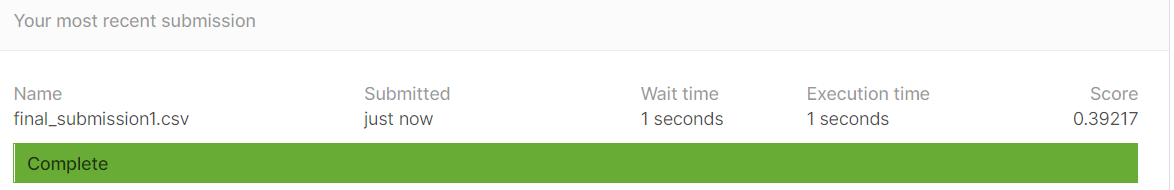

In [25]:
from PIL import Image
img=Image.open("../Submissions/2clfs.png")
img